In [1]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
import time
from IPython.display import HTML, display
! pip install tabulate
import tabulate
import numpy as np
from scipy.io import savemat
import gc
from tensorflow.keras.models import model_from_json
!pip install tqdm
!pip install h5py
import zipfile
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing
from tensorflow.keras.models import model_from_json

In [2]:
def scale(x):

    return (x - np.mean(x)) / np.std(x)

In [3]:
def preprocess(x):
    
    return x[:,:,:int(0.75*x.shape[2])]

In [4]:
os.chdir("/home/pk2573")
path = "/home/pk2573/Capstone_Data"

In [5]:
json_file = open('model_tau_12.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_tau_12 = model_from_json(loaded_model_json)
model_tau_12.load_weights("model_tau_12.h5")
model_tau_12.compile(loss = 'mse', optimizer = tf.train.AdamOptimizer())

In [6]:
json_file = open('model_tau_13.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_tau_13 = model_from_json(loaded_model_json)
model_tau_13.load_weights("model_tau_13.h5")
model_tau_13.compile(loss = 'mse', optimizer = tf.train.AdamOptimizer())

In [7]:
json_file = open('model_tau_23.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_tau_23 = model_from_json(loaded_model_json)
model_tau_23.load_weights("model_tau_23.h5")
model_tau_23.compile(loss = 'mse', optimizer = tf.train.AdamOptimizer())

In [8]:
subdirs = [subdir for subdir, dirs, files in os.walk(path)]
try:
    subdirs.remove(path + "/.ipynb_checkpoints")
    subdirs.remove(path + "/Re1243Fr20/.ipynb_checkpoints")
    subdirs.remove(path + "/Re1243Fr20/coarse8/.ipynb_checkpoints")
    subdirs.remove(path + "/Re1243Fr20/coarse16/.ipynb_checkpoints")
    subdirs.remove(path + "/Re1243Fr20/coarse16/.ipynb.mat")
    subdirs.remove(path + "/Re1243Fr20/coarse24/.ipynb.mat")
    subdirs.remove(path + "/Re546/.ipynb_checkpoints")
    subdirs.remove(path + "/Re546/coarse8/.ipynb_checkpoints")
    subdirs.remove(path + "/Re546/coarse16/.ipynb_checkpoints")
    subdirs.remove(path + "/Re546/coarse24/.ipynb_checkpoints")
    subdirs.remove(path + "/Re554Fr5/.ipynb_checkpoints")
    subdirs.remove(path + "/Re554Fr5/coarse16/.ipynb_checkpoints")
    subdirs.remove(path + "/Re554Fr5/coarse24/.ipynb_checkpoints")
    subdirs.remove(path + "/Re309Fr2/.ipynb_checkpoints")
    subdirs.remove(path + "/Re309Fr2/coarse8/.ipynb.mat")
    subdirs.remove(path + "/Re309Fr2/coarse16/.ipynb_checkpoints")
    subdirs.remove(path + "/Re309Fr2/coarse24/.ipynb_checkpoints")
    subdirs.remove(path + "/Re309Fr2/coarse16/.ipynb.mat")
    subdirs.remove(path + "/Re309Fr2/coarse24/.ipynb.mat")
    subdirs.remove(path + "/Re546")
    subdirs.remove(path + "/Re554Fr5")
    subdirs.remove(path + "/Re1243Fr20")
    subdirs.remove(path + "/Re309Fr2")

except:
    pass

subdirs = sorted(subdirs[1:])
subdirs = subdirs[6:9]
subdirs

['/home/pk2573/Capstone_Data/Re546/coarse16',
 '/home/pk2573/Capstone_Data/Re546/coarse24',
 '/home/pk2573/Capstone_Data/Re546/coarse8']


Timestep: 1
Running Re546_coarse16
Running Re546_coarse24
Running Re546_coarse8


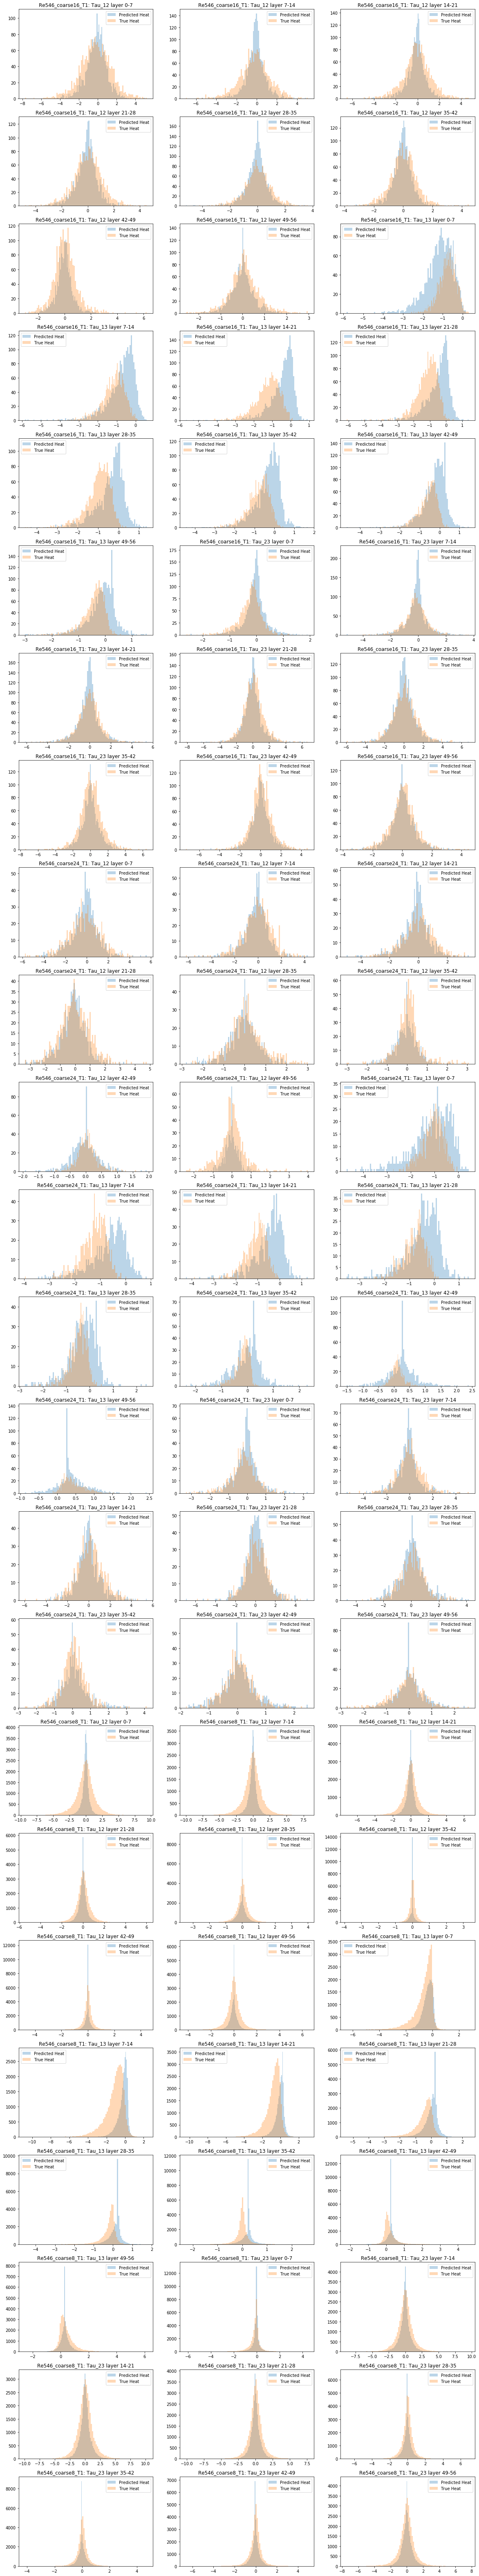

In [14]:
count = 1
fig = plt.figure(figsize = (20, 144))
for m in [1]:
    print("\nTimestep:", str(m))
    for path in subdirs:
        os.chdir(path)
        
        try:
            u = loadmat('u_F_xyz_T' + str(m) + '.mat')
            u = preprocess(scale(u[list(u.keys())[-1]]))
            v = loadmat('v_F_xyz_T' + str(m) + '.mat')
            v = preprocess(scale(v[list(v.keys())[-1]]))
            w = loadmat('w_F_xyz_T' + str(m) + '.mat')
            w = preprocess(scale(w[list(w.keys())[-1]]))
            tau_12 = loadmat('tau12_F_xyz_T' + str(m) + '.mat')
            tau_12 = preprocess(scale(tau_12[list(tau_12.keys())[-1]]))
            tau_13 = loadmat('tau13_F_xyz_T' + str(m) + '.mat')
            tau_13 = preprocess(scale(tau_13[list(tau_13.keys())[-1]]))
            tau_23 = loadmat('tau23_F_xyz_T' + str(m) + '.mat')
            tau_23 = preprocess(scale(tau_23[list(tau_23.keys())[-1]]))

            print("Running " + path.split("/")[-2] + "_" + path.split("/")[-1])

            x = np.array([u, v, w])
            x = np.transpose(x, [1, 2, 3, 0])
            x = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)

            del v
            del w
            gc.collect()

            sample = []
            size = 3
            y_tau_12 = []
            y_tau_13 = []
            y_tau_23 = []
            for i in range(size, x.shape[2] - size):
                for j in range(size, x.shape[0] - size):
                    for k in range(size, x.shape[1] - size):
                        sample.append(x[j - size: j + size + 1, k - size: k + size + 1, i - size: i + size + 1, :])
                        y_tau_12.append(tau_12[j - size][k - size][i - size])
                        y_tau_13.append(tau_13[j - size][k - size][i - size])
                        y_tau_23.append(tau_23[j - size][k - size][i - size])

            x = np.array(sample)

            y_tau_12 = np.array(y_tau_12)
            y_tau_13 = np.array(y_tau_13)
            y_tau_23 = np.array(y_tau_23)

            del sample
            gc.collect()

            output = [(y_tau_12, "Tau_12", model_tau_12), (y_tau_13, "Tau_13", model_tau_13), (y_tau_23, "Tau_23", model_tau_23)]

            corrs = []
            for (y_true, name, model) in output:
                for num in range(8):
                    subset = x[num * int(u.shape[2] / 8) * u.shape[0] * u.shape[1] : (num + 1) * int(u.shape[2] / 8) * u.shape[0] * u.shape[1]]
                    y_pred = model.predict(subset).flatten()
                    y_tr = y_true[num * int(u.shape[2] / 8) * u.shape[0] * u.shape[1]: (num + 1) * int(u.shape[2] / 8) * u.shape[0] * u.shape[1]]
                    corrs.append(np.corrcoef(y_pred, y_tr)[0, 1])

                    fig.add_subplot(30, 3, count)
                    n_bins = 100
                    plt.hist(y_pred, bins = n_bins, alpha = 0.3, label = "Predicted Heat")
                    plt.hist(y_tr, bins = n_bins, alpha = 0.3, label = "True Heat")
                    plt.title(path.split("/")[-2] + "_" + path.split("/")[-1] + str("_T" + str(m)) + ": " + name + " layer " + str((num) * 7) + "-" + str((num + 1) * 7))
                    plt.legend()
                    plt.show

                    count += 1

            del x
            del y_tau_12
            del y_tau_13
            del y_tau_23
            del model
            del u
            del y_pred
            del y_true
            gc.collect()

        except:
            pass